In [38]:
import pickle
import json
from random import randint, shuffle
from tqdm import tqdm
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict
from espncricinfo.match import Match

In [5]:
def plotHist(data, bins=[], x_labels=True):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    if bins: 
        counts, bins, patches = ax.hist(data, bins=bins, facecolor='yellow', edgecolor='gray')
    else:
        counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    if x_labels:
        ax.set_xticks(bins)
        # Set the xaxis's tick labels to be formatted with 1 decimal place...
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.05f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    if x_labels:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [6]:
def load_data(filename):
    with open(f"{filename}.pkl", "rb") as f:
        data = pickle.load(f)
    print("Loaded data!")
    return data
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
    
def getRandomMatch(data):
    return data[match_ids[randint(0, 1919)]]

def printInnings(data, matchId, inningsNum, summaries=False, highlightOnly=False):
    if summaries:
        for over in data[matchId]['commentary'][f'innings{inningsNum}']['over_summaries']:
            if highlightOnly:
                print(over[0])
            else:
                print(over)
    else:
        for ball in data[matchId]['commentary'][f'innings{inningsNum}']['balls']:
            print(ball)
            
i1 = lambda m : m['commentary']['innings1']
i2 = lambda m : m['commentary']['innings2']

In [17]:
data, players = load_data("matches_with_details"), load_data("player_table")

Loaded data!
Loaded data!


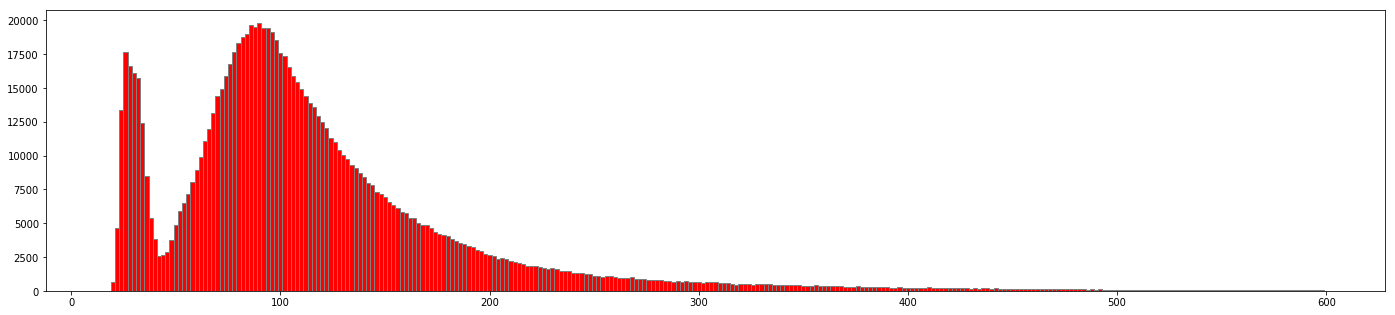

In [18]:
lengths = []
count = 0
over_summary = set()
ball_samples = defaultdict(list)
for i, m in data.items():
    for b in i1(m)['balls']:
        over_summary.add(b['number'])
        comms = b['desc']
        lengths.append(len(comms))
        ball_samples[len(comms)].append(comms)
        
    for b in i2(m)['balls']:
        over_summary.add(b['number'])
        lengths.append(len(b['desc']))

plotHist(lengths, bins=list(range(17,600, 2)), x_labels=False)

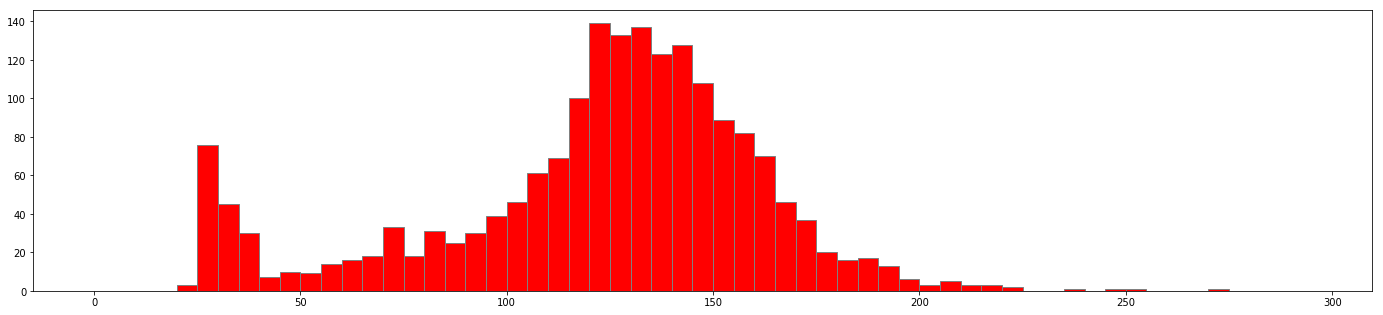

In [19]:
lengths = []
ball_samples = defaultdict(list)
for i, m in data.items():
    match_lengths = []
    for b in i1(m)['balls']:
        comms = b['desc']
        match_lengths.append(len(comms))
        
    for b in i2(m)['balls']:
        comms = b['desc']
        match_lengths.append(len(comms))
        
    avg_length = (sum(match_lengths)/len(match_lengths))
    ball_samples[avg_length // 5].append(i)
    lengths.append(avg_length)

plotHist(lengths, bins=list(range(0,300, 5)), x_labels=False)

In [20]:
total_with_commentary = 0
for k in sorted(ball_samples.keys()):
    if k >= 15:
        total_with_commentary += len(ball_samples[k])
print(total_with_commentary)
    

1608


In [21]:
def resetBalls():
    for i, m in data.items():
        newBalls = []
        for b in i1(m)['balls']:
            ball_data = {}
            ball_data['number'] = b[0]
            ball_data['outcome'] = b[1]
            ball_data['desc'] = ",".join(b[2::])
            ball_data['pitch'] = {}
            newBalls.append(ball_data)

        m['commentary']['innings1']['balls'] = newBalls
        newBalls = []
        for b in i2(m)['balls']:
            ball_data = {}
            ball_data['number'] = b[0]
            ball_data['outcome'] = b[1]
            ball_data['desc'] = ",".join(b[2::])
            ball_data['pitch'] = {}
            newBalls.append(ball_data)
        m['commentary']['innings2']['balls'] = newBalls

In [22]:
def downloadMatchDetails():
    count = 0
    for i, m in tqdm(data.items()):
        count += 1
        if not 'batting_first' in m:
            espnMatch = Match(i)
            m['batting_first'] = espnMatch.batting_first
            m['ground_id'] = espnMatch.ground_id
            m['home_team'] = espnMatch.home_team
        if count % 20 == 0:
            save_data(data, "matches_with_details")
    save_data(data, "matches_with_details")

In [23]:
bf = set()
ht = set()
gi = set()
teams = set()
for i, m in data.items():
    bf.add(m['batting_first'])
    ht.add(m['home_team'])
    gi.add(m['ground_id'])
    teams.add(m['team1'])
    teams.add(m['team2'])

print(bf)
print(teams)

{'ZIM', 'NZ', 'PAK', 'NL', 'INDIA', 'NAM', 'SA', 'HKG', 'SL', 'IRE', 'AUS', 'USA', 'ENG', 'UAE', 'CAN', 'BDESH', 'SCOT', 'BMUDA', 'NEPAL', 'KENYA', 'AFG', 'PNG', 'WI'}
{'P.N.G.', 'India', 'Canada', 'Kenya', 'New Zealand', 'Oman', 'Nepal', 'Ireland', 'Hong Kong', 'Scotland', 'Pakistan', 'Namibia', 'U.S.A.', 'Bangladesh', 'Zimbabwe', 'Sri Lanka', 'South Africa', 'U.A.E.', 'West Indies', 'Australia', 'Afghanistan', 'Bermuda', 'Netherlands', 'England'}


In [24]:
import difflib
team = {}
for t in teams:
    closest = difflib.get_close_matches(t.upper(), list(bf))
    team[t] = closest
team['Australia'] = ['AUS']
team['Zimbabwe'] = ['ZIM']
team['New Zealand'] = ['NZ']
team['West Indies'] = ['WI']
team['Pakistan'] = ['PAK']
team['Hong Kong'] = ['HKG']
team['Afghanistan'] = ['AFG']
team['South Africa'] = ['SA']
del team['Oman']
team['Sri Lanka'] = ['SL']
team['Netherlands'] = ['NL']

In [26]:
for k, v in team.items():
    team[k] = v[0]
team_to_id = team
id_to_team = {v: k for k, v in team_to_id.items()} 

In [83]:
from difflib import SequenceMatcher
def getPlayerProfile(name):
    returnList = [] 
    for i, p in players.items():
        match = SequenceMatcher(a=p['known_as'].lower(), b=name.lower()).ratio()
        if match > 0.6:
            returnList.append((p, match))
            
    return [i[0] for i in sorted(returnList, key = lambda x : x[1], reverse=True)]

def getNameSet(player_profile):
    name_set = set()
    name_set.add(player_profile['mobile_name'].lower())
    name_set.update(player_profile['card_long'].lower().split(' '))
    name_set.update(player_profile['known_as'].lower().split(' '))
    return name_set

In [126]:
overNumberPattern = '^(?P<over>\d+)\.\d+$'
def getDescWordSet(desc):
    return set(desc.lower().translate(str.maketrans('', '', string.punctuation)).split(' '))

def checkIfPlayerBowledOver(profile, balls, over):
    names = getNameSet(profile)
    validOver = False
    for b in balls:
        overNum = int(re.match(overNumberPattern, b['number']).group('over'))
        if overNum == over:
            validOver = True
            desc = getDescWordSet(b['desc'])
            if not names.intersection(desc):
                return False
    return validOver

def getOver(balls, over):
    retBalls = []
    for i, b in enumerate(balls):
        overNum = int(re.match(overNumberPattern, b['number']).group('over'))
        if overNum == over:
            retBalls.append(i)
    return retBalls

def getPlayerBalls(profile, balls):
    overs = []
    for o in range(0,51):
        if checkIfPlayerBowledOver(profile, balls, o):
            overs += getOver(balls, o)
    return sorted(overs)

In [136]:
matches = list(data.keys())
num = 814

player = 'Piyush Chawla'
profile = getPlayerProfile('Piyush Chawla')[0]
balls = i2(data[matches[num]])['balls']
for b in getPlayerBalls(profile, balls):
    print(f"{balls[b]['number']:<5} | {balls[b]['desc'][:100]:>100}")

48.6  | Chawla to Bresnan, OUT, Chawla strikes back! One way and another this match is going! Bresnan tried 
48.5  | Chawla to Bresnan, SIX runs, Bresnan has nailed this! Not another twist, surely! Down one knee, clea
48.4  | Chawla to Bresnan, 2 runs, ooh, Bresnan trying to match Swann but can't quite time it as well. Press
48.3  | Chawla to Swann, 1 run, Swann down the wicket now to try and swing a similar shot, this one skews of
48.2  | Chawla to Swann, SIX runs, absolute silence as Swann is on the sweep again. This time getting all of
48.1  | Chawla to Swann, no run, big slog sweep attempted, but Swann only finds fresh air,Righty, Chawla on.
43.6  | Chawla to Prior, no run, suddenly the fielding has picked up too! Oh cricket. Prior laces a drive to
43.5  | Chawla to Prior, no run, short ball sat up asking for trouble, Prior screamed it but straight to cov
43.5  | Chawla to Prior, 1 wide, another wrong 'un, line was wrong as well though and it slipped down the le
43.4  | Chawla to P

In [135]:
bumrah = getPlayerProfile('Jasprit Bumrah')[0]
m_id = '895815'
balls = i1(data[m_id])['balls']

for b in getPlayerBalls(bumrah, balls):
    print(f"{balls[b]['number']:<5} | {balls[b]['desc'][:100]:>100}")

48.6  | Bumrah to MR Marsh, no run, low full-toss on off stump and Marsh cannot whip it past mid-on, who has
48.5  |      Bumrah to MR Marsh, no run, in the blockhole close to off stump, jabbed back hard to the bowler
48.4  | Bumrah to Hastings, 1 run, slower ball outside off, Hastings defends into the off side with soft han
48.3  | Bumrah to MR Marsh, 1 run, yorker close to off stump, whipped to long-on. Thinks about the second to
48.2  | Bumrah to Hastings, 1 run, another one in the blockhole, middle-and-off, not quite a yorker this tim
48.1  | Bumrah to Faulkner, OUT, oh, Bumrah, what a delivery. Takes out Faulkner's off stump with a perfect 
44.6  | Bumrah to Wade, 1 leg bye, sees him coming down the pitch and follows with a full ball at his feet. 
44.5  | Bumrah to Wade, no run, yorker on leg stump and Wade has to pull his feet out of the way in a hurry 
44.4  |                         Bumrah to MR Marsh, 1 run, near-yorker on off stump, clipped towards long-on
44.3  | Bumrah to M

In [141]:
def getAllPlayerOvers(playerName):
    overs = []
    profile = getPlayerProfile(playerName)[0]
    p_id = profile['player_id']
    for i, m in data.items():
        # Check which team player is in, if any
        if p_id in m['team_1_players']:
            team = m['team1']
        elif p_id in m['team_2_players']:
            team = m['team2']
        else:
            continue
        
        # Check which innings player bowled in
        team_id = team_to_id[team]
        inn = 1
        if team_id == m['batting_first']:
            inn = 2
            
        # Get all balls from match
        balls = getPlayerBalls(profile, m['commentary'][f'innings{inn}']['balls'])
        overs.append((i, inn, balls))
    return overs

In [167]:
def printBowlerBalls(name, onlyCount = True, outcome='any'):
    matches = getAllPlayerOvers(name)
    num_balls = 0
    for i, inn, playerBalls in matches:
        balls = data[i]['commentary'][f'innings{inn}']['balls']
        if not onlyCount:
            for b in playerBalls:
                if outcome != 'any':
                    if balls[b]['outcome'] == outcome:
                        num_balls += 1
                        print(f"{balls[b]['number']:<5} | {balls[b]['desc'][:180]:<180}")
                else:
                    num_balls += 1
                    print(f"{balls[b]['number']:<5} | {balls[b]['desc'][:180]:<180}")
                    
    if onlyCount: return num_balls

In [171]:
printBowlerBalls("Ravichandran Ashwin", False, 'W')

36.3  | Ashwin to Hussey, OUT, this time the lbw appeal is upheld, Hussey looked to be tiring over the past few overs, a short of length ball, Hussey looks to pull that one, he misses and 
36.4  | Ashwin to Guptill, OUT, given out caught-behind by Hazare, fires a carrom ball on the off stump and it goes the other way, Guptill tries to crash that through the line, and Saha cl
47.2  | Ashwin to NL McCullum, OUT, the partnership is broken, makes room, turns in and he tries to smack that over extra cover but doesn't get the desired elevation, straight to Gambhir  
22.6  | Ashwin to Styris, OUT, good catch by Yuvraj at leg slip, tossed up on middle and leg, Styris, who had struggled to pinch a single for the previous four deliveries, turned the face 
37.1  | Ashwin to Taylor, OUT, plumb lbw first ball! A nothing shot really! Moves too far across, and also seems to have told himself to not play the forceful shot first ball. And the bat 
13.2  | Ashwin to BB McCullum, OUT, big, big wicket! Mc

In [55]:
for i, m in data.items():
    d = i1(m)['balls'][0]['desc']
    print(d)
    if getDescWordSet(d).intersection({'leehmann'}): print(True)
    break

Bravo to Lehmann, FOUR runs,


In [82]:
x = set()
x.update('munaf patel'.split(' '))
x

{'munaf', 'patel'}

In [103]:
save_data(data, "clean_matches")

In [104]:
export_to_json(data)